In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import time
import math

%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [23]:
#v=list(os.walk('./zdjs/light_set'))
v=list(os.walk('./zdjs/Trivial'))

f=[0]*200
j=0
for i in range(0, len(v)):
    for x in (v[i][2]):
        f[j]=cv.imread(v[i][0]+'/'+x, cv.IMREAD_GRAYSCALE)
        j+=1
        
def grave(img, biw=0):
    fig, ax=plt.subplots(1,1,figsize=(22,22))
    if (biw==1):
        ax.imshow(img, cmap='Greys',  interpolation='nearest')
    else:
        ax.imshow(img)
    plt.show()
    return

def decorate(i):
    print()
    print('#'*30+'   '+str(i)+'   '+'#'*30)
    print()

In [24]:
%%cython
import numpy as np
import math
cimport numpy as np
from cpython cimport array
import array


def blackening(np.ndarray[unsigned char, ndim=2] bwimg, np.ndarray[long, ndim=2] path):
    cdef int s=0, t=0, gr=0, ij, i, jj
    cdef np.ndarray[int, ndim=1] dep=np.zeros((len(path)), dtype='int32')
    cdef np.ndarray[int, ndim=1] end1=np.zeros((len(path)), dtype='int32')
    cdef np.ndarray[int, ndim=1] end2=np.zeros((len(path)), dtype='int32')
    
    for i in range(0, len(path)):
        for ij in range(0, -10, -1):
            a, b=path[i][0]+ij, path[i][1]
            if (bwimg[a,b]==255):
                break
        end1[i]=ij
        
        for ij in range(1, 10, 1):
            a, b=path[i][0]+ij, path[i][1]
            
            if (bwimg[a,b]==255):
                break
        end2[i]=ij
        
        dep[i]=end2[i]-end1[i]
    ld=len(dep)
    dep2=sorted(dep)
    small=dep2[math.floor(0.1*ld)]
    large=dep2[math.floor(0.9*ld)]
    
    dep2=dep2[math.floor(0.1*ld):math.floor(0.9*ld)]
    grub=sum(dep2)/len(dep2)-2
    #print('DEPTH {} {}'.format(grub, dep))
    
    midian=[0]*len(path)
    cur=0
    last=0
    midian[0]=path[0][0]
    for i in range(1, len(path)):
        if (dep[i]>grub+3):
            cur+=1
            continue
        else:
            midian[i]=path[i][0]+(end2[i]+end1[i])//2
            while (cur>0):
                p=path[i][0]-cur
                midian[i-cur]=midian[i] if (cur<p-last) else midian[last]
                tv=midian[i-cur]
                jj=1
                while (bwimg[tv, path[i-cur][1]]==255):
                    tv=tv+jj
                    jj=-jj-1*jj//abs(jj) 
                midian[i-cur]=tv
                cur-=1
            last=i
            
    #print(list(zip(path, midian)))
    dt0=math.ceil(grub)
    for i in range(len(path)):
        sc, t1, t2=0, 0, 0
        for jj in range(1, 10):
            if (bwimg[midian[i]+jj, path[i][1]]==255):
                break
        t1=jj
        for jj in range(0, -10, -1):
            if (bwimg[midian[i]+jj, path[i][1]]==255):
                break
        t2=jj
        sc=t1-t2
        
        if (sc<=dt0+3):
            for jj in range(t2, t1+1, 1):
                bwimg[midian[i]+jj, path[i][1]]=255
    c1=math.floor(0.1*len(midian))
    c2=math.floor(0.9*len(midian))
    
    return (sum(midian[c1:c2])/len(midian[c1:c2]), grub)


def cleanblack(bwimg, pathway):
    for x in pathway:
        bwimg[x[0]-2:x[0]+2,x[1]]=255
    return (1,2)

#limit - o ile y może się odchylić od y2
def pathfinder(np.ndarray[unsigned char, ndim=2] bwimg, F, np.ndarray[unsigned char, ndim=2] check, np.ndarray[int, ndim=1] par, np.ndarray[int, ndim=1] w, awp, awm, int y, int x, int p, int vv, int lowx, int highx, int y2, np.ndarray[int, ndim=1] miss):
    cdef int limit=30, l2=6
    
    if (y>=bwimg.shape[0] or x>=bwimg.shape[1] or x<0 or y<0 or abs(y-y2)>limit):
        return (p, lowx, highx)
    if (check[y,x]==0 and (bwimg[y,x]==0 or miss[vv]<l2)):
        if (bwimg[y,x]==255):
            miss[p]=miss[vv]+1
        else:
            miss[p]=0
        F.append((y, x))
        check[y,x]=1
        par[p]=vv
        if (x<lowx):
            lowx=x
            awm.append(p)
            w[p]=-1
        elif (x>highx):
            highx=x
            awp.append(p)
            w[p]=1
        else:
            w[p]=0
        return (p+1, lowx, highx)
    return (p, lowx, highx)


def findlinez(np.ndarray[unsigned char, ndim=2] bwimg, shp):
    cdef int skv=2, y=1, kk=1, iF=0, jF=1, deadl=0, deadr=1, highx, lowx, x1, x2, conn=1000, C=100000
    solution=[]
    cdef np.ndarray[unsigned char, ndim=2] check=np.zeros((bwimg.shape[0], bwimg.shape[1]), dtype='uint8')
    cdef np.ndarray[int, ndim=1] par=np.zeros((C), dtype='int32')
    cdef np.ndarray[int, ndim=1] miss=np.zeros((C), dtype='int32')
    cdef np.ndarray[int, ndim=1] w=np.zeros((C), dtype='int32')
    
    for kk in range(1, skv):
        y=1
        x1=(kk*bwimg.shape[1])//skv-2
        x2=(kk*bwimg.shape[1])//skv+2
        
        while (y<bwimg.shape[0]-1):
            vs=bwimg[y,x1:x2+1]
            if (0 in vs):
                xl=kk*(bwimg.shape[1]//skv)
                yl=y
                
                pathway=[]
                F=[(yl, xl)]
                par[0]=-1
                w[0]=0
                awp=[]
                awm=[]
                miss[0]=0
                
                highx, lowx=xl, xl
                deadl, deadr=0, 0
                pointdead=[0,0]
                iF, jF=0, 1
                conn=1000
                
                while(iF<jF):
                    s=F[iF]
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, awp, awm, s[0]-1, s[1], jF, iF, lowx, highx, y, miss)
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, awp, awm, s[0]+1, s[1], jF, iF, lowx, highx, y, miss)
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, awp, awm, s[0], s[1]-1, jF, iF, lowx, highx, y, miss)
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, awp, awm, s[0], s[1]+1, jF, iF, lowx, highx, y, miss)
                    
                    if (len(awp)>4 and awp[-5]<jF-conn and deadr==0):
                        deadr=1
                        pointdead[1]=jF-conn
                    if (len(awm)>4 and awm[-5]<jF-conn and deadl==0):
                        deadl=1
                        pointdead[0]=jF-conn
                    if (deadl==1 and deadr==1):
                        break
                    iF+=1
                if (pointdead[0]==0):
                    pointdead[0]=jF-1
                if (pointdead[1]==0):
                    pointdead[1]=jF-1
                #print(y, jF, lowx, highx)
                #print('PedE', pointdead, jF, highx, lowx)
                j1=pointdead[0]
                for j1 in range(pointdead[0], -1, -1):
                    if (w[j1]==-1):
                        break
                while (j1>=0):
                    pathway.append(F[j1])
                    j1=par[j1]
                
                j2=pointdead[1]
                for j2 in range(pointdead[1], -1, -1):
                    if (w[j2]==1):
                        break
                
                p2=[]
                while (j2>0):
                    p2.append(F[j2])                    
                    j2=par[j2]
                
                pathway.extend(p2[::-1])
                for x in F:
                    check[x[0], x[1]]=0
                
                if (highx-lowx>shp[1]*0.15):
                    sv, gr=blackening(bwimg, np.asarray(pathway))
                    #sv, gr=cleanblack(bwimg, pathway)
                    solution.append((sv, gr, lowx, highx))
            y+=1
    return solution


##############################   0   ##############################



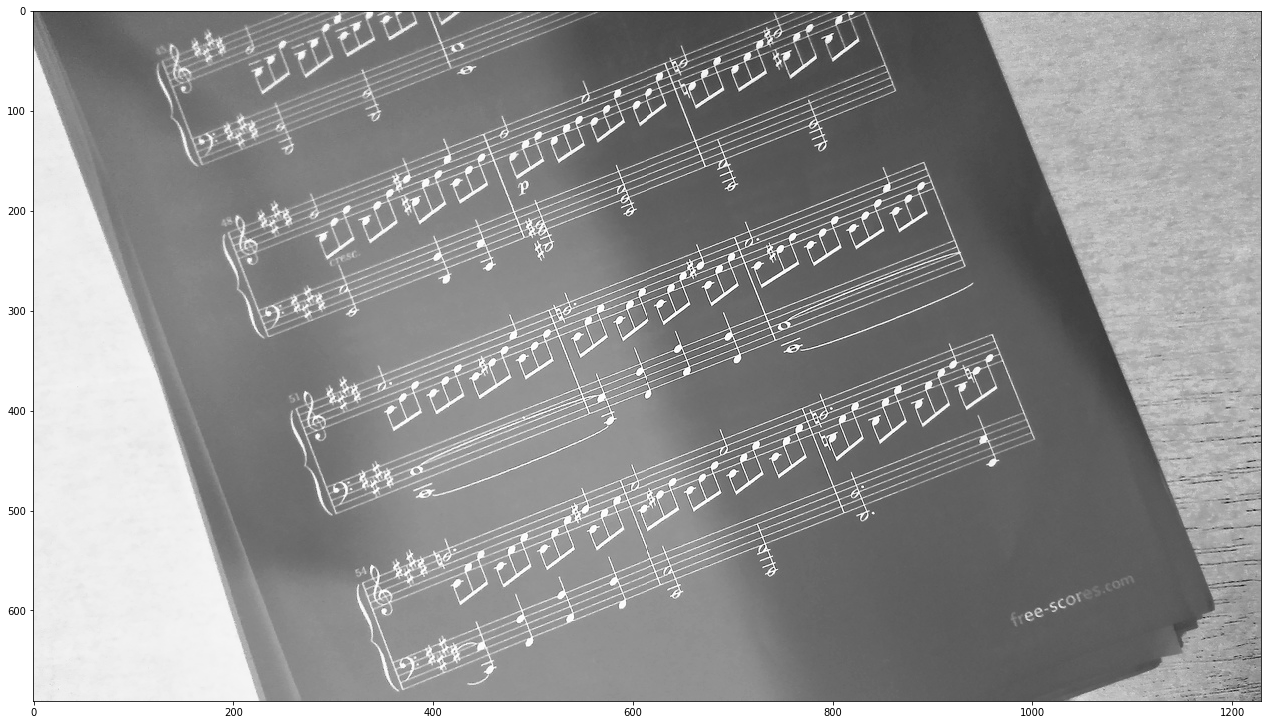

691 1229 -20.487315114722662 -0.35


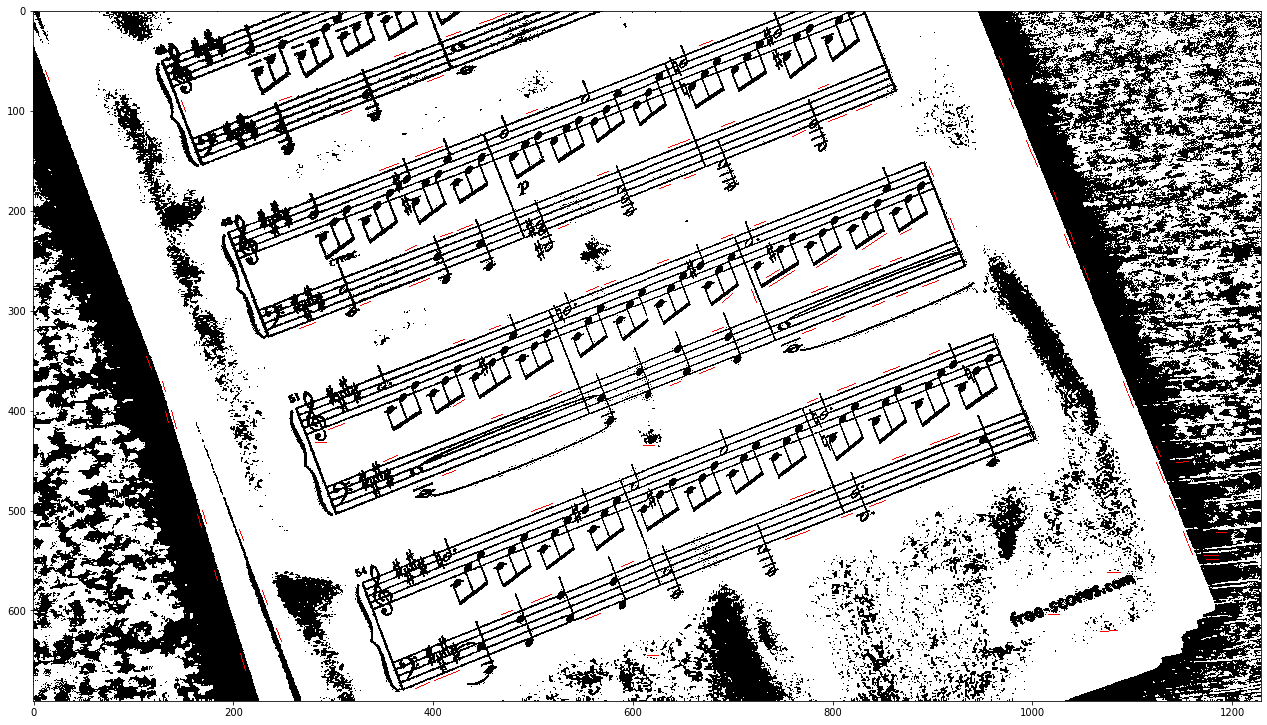

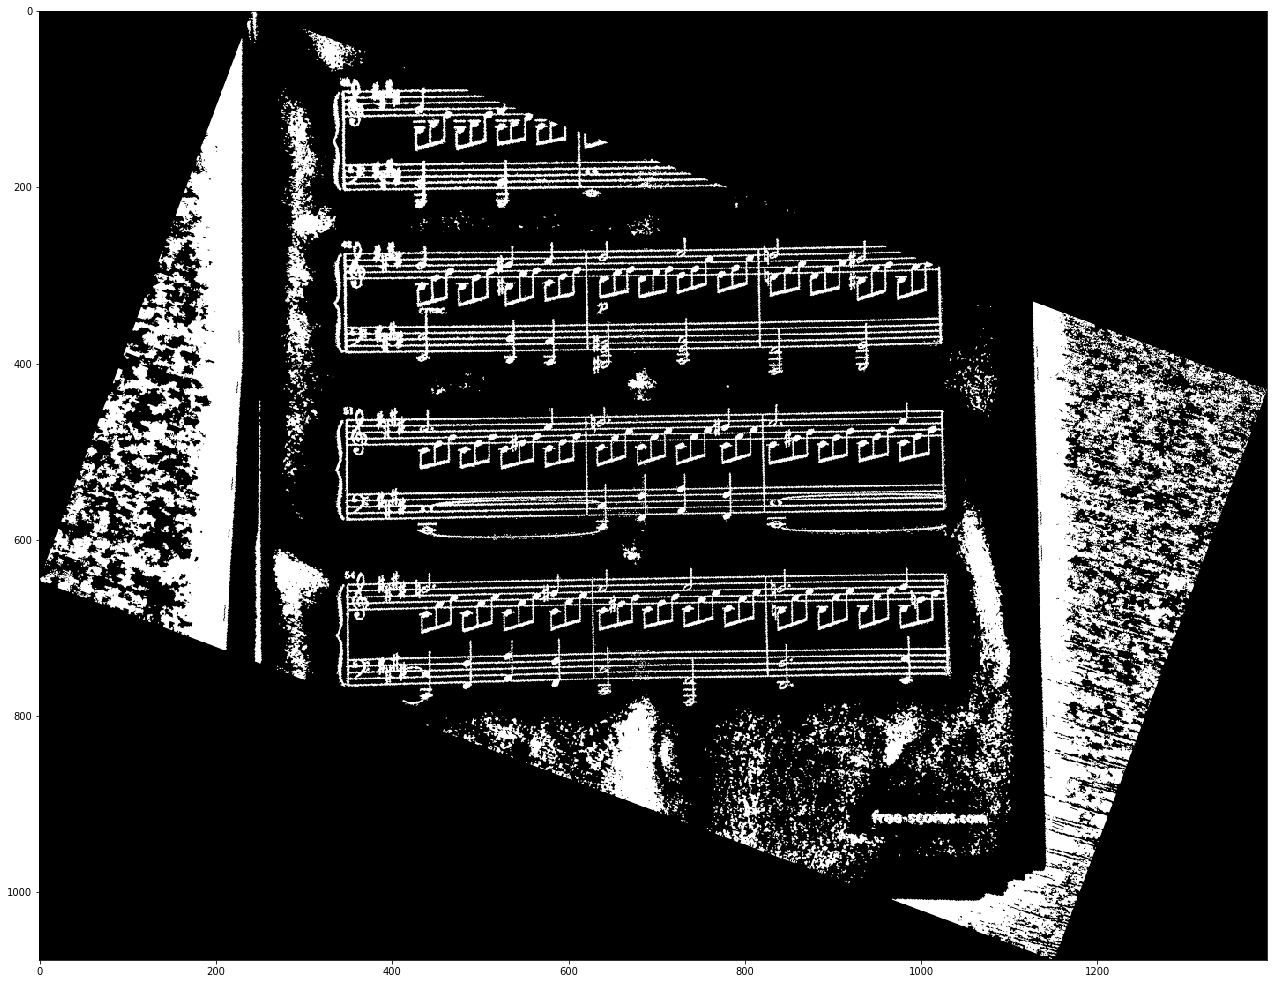

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(1.0, 16.0, 0, 1412)
(186.34715025906735, 2.9507772020725387, 337, 795)
(190.3070652173913, 3.7228260869565215, 337, 775)
(196.14772727272728, 4.025568181818182, 337, 756)
(204.2158054711246, 3.7294832826747717, 337, 739)
(210.82558139534885, 3.4593023255813957, 337, 731)
(297.1207482993197, 3.1309523809523814, 338, 1038)
(290.5498220640569, 2.9466192170818504, 339, 1029)
(304.4703196347032, 3.666666666666667, 339, 1026)
(307.5548387096774, 3.990322580645161, 374, 1026)
(312.2429022082019, 4.1892744479495265, 339, 998)
(365.63101604278074, 2.1818181818181817, 339, 1041)
(372.6185383244207, 2.5632798573975046, 339, 1041)
(379.76190476190476, 2.7830687830687832, 339, 1041)
(386.62300884955755, 2.5858407079646017, 340, 1041)
(393.569176882662, 2.523642732049037, 340, 1041)
(477.7405498281787, 1.8144329896907219, 340, 1043)
(477.23117338003505, 2.4430823117338, 341, 1043)
(490.92768959435625, 3.112874779541446, 

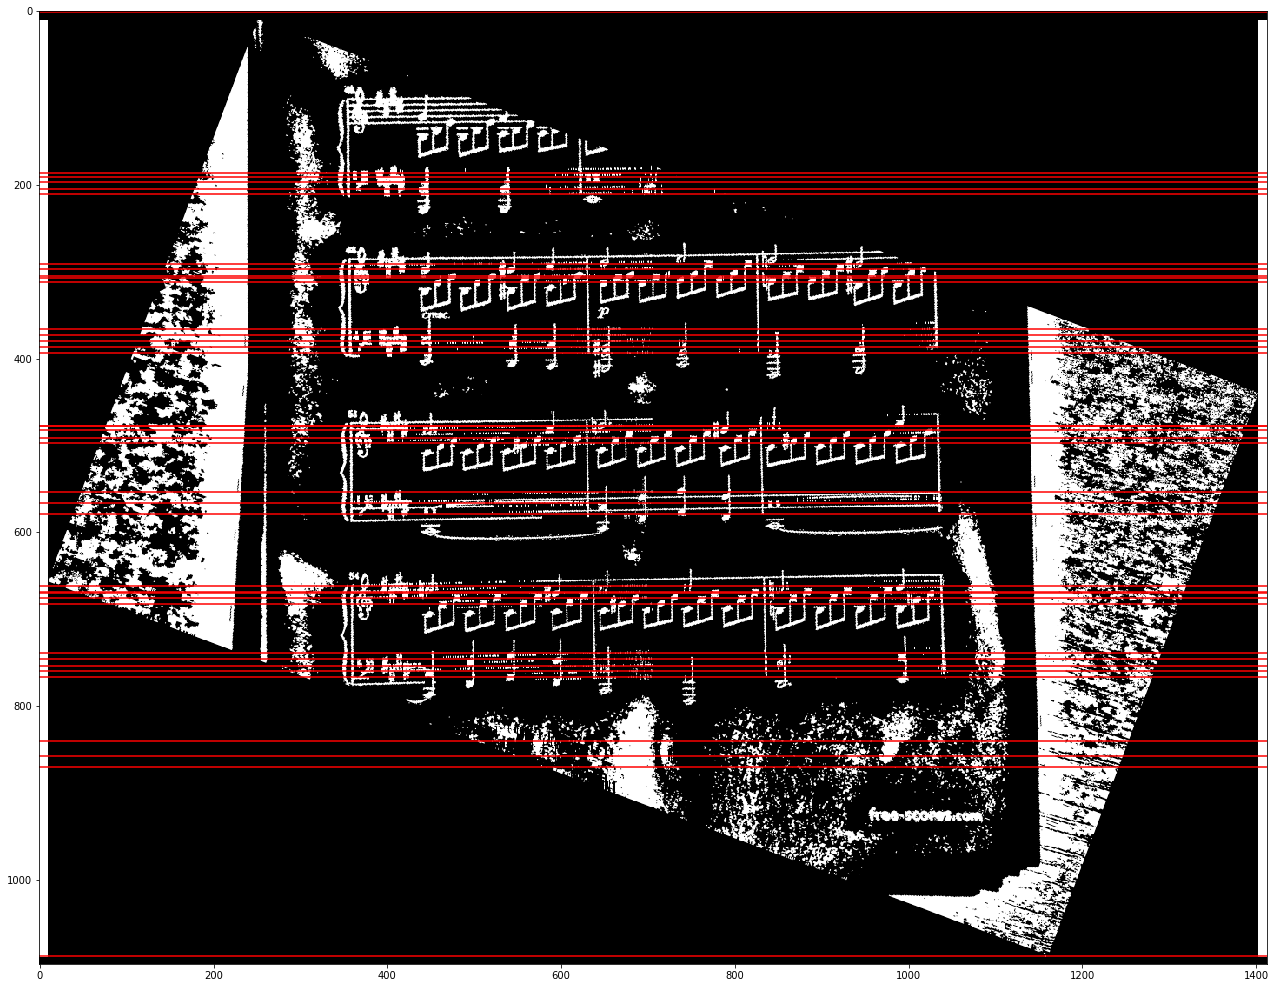

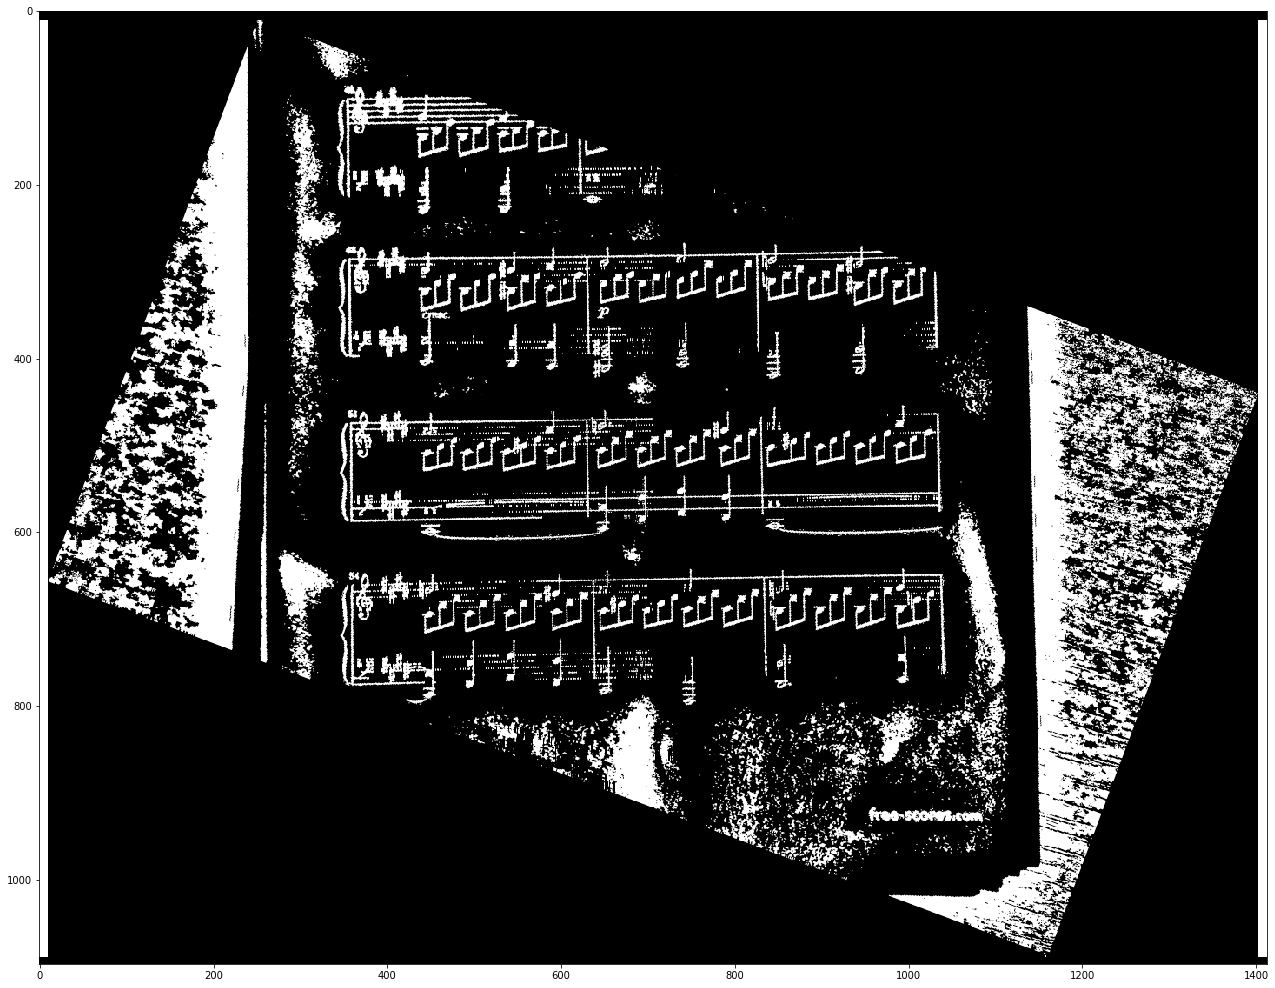

10.398146867752075

##############################   1   ##############################



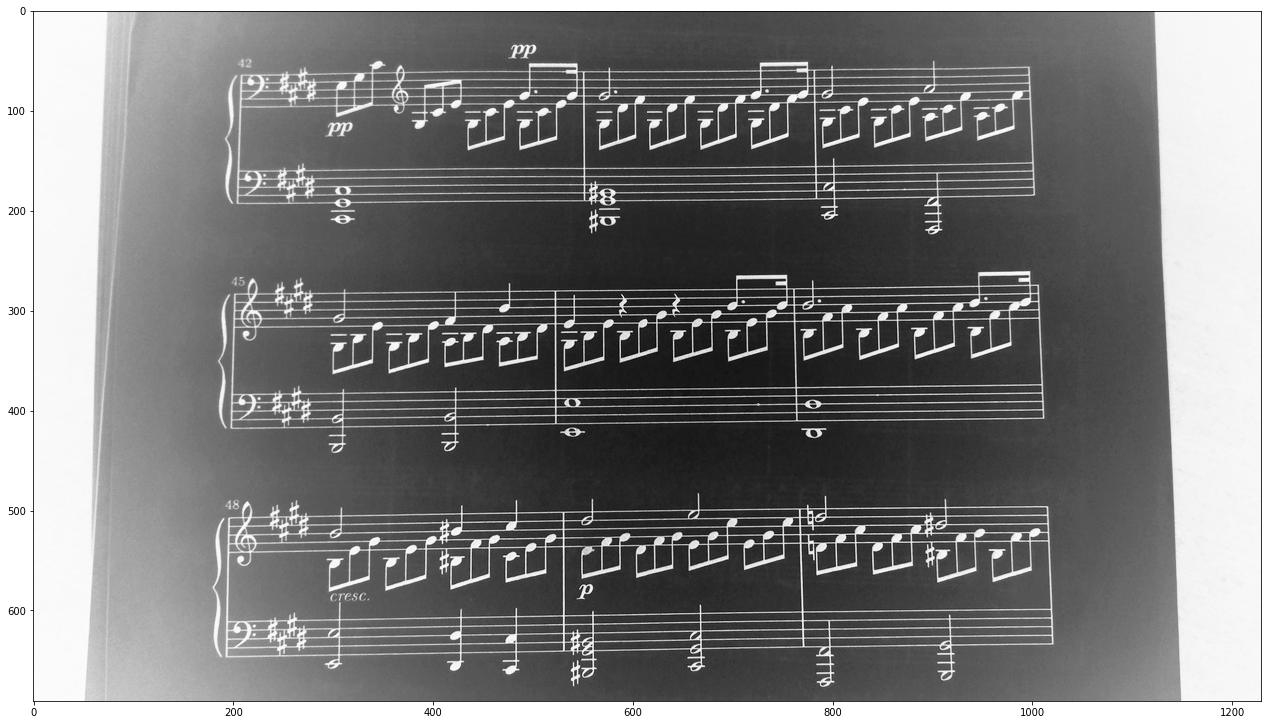

691 1229 0.0 0.0


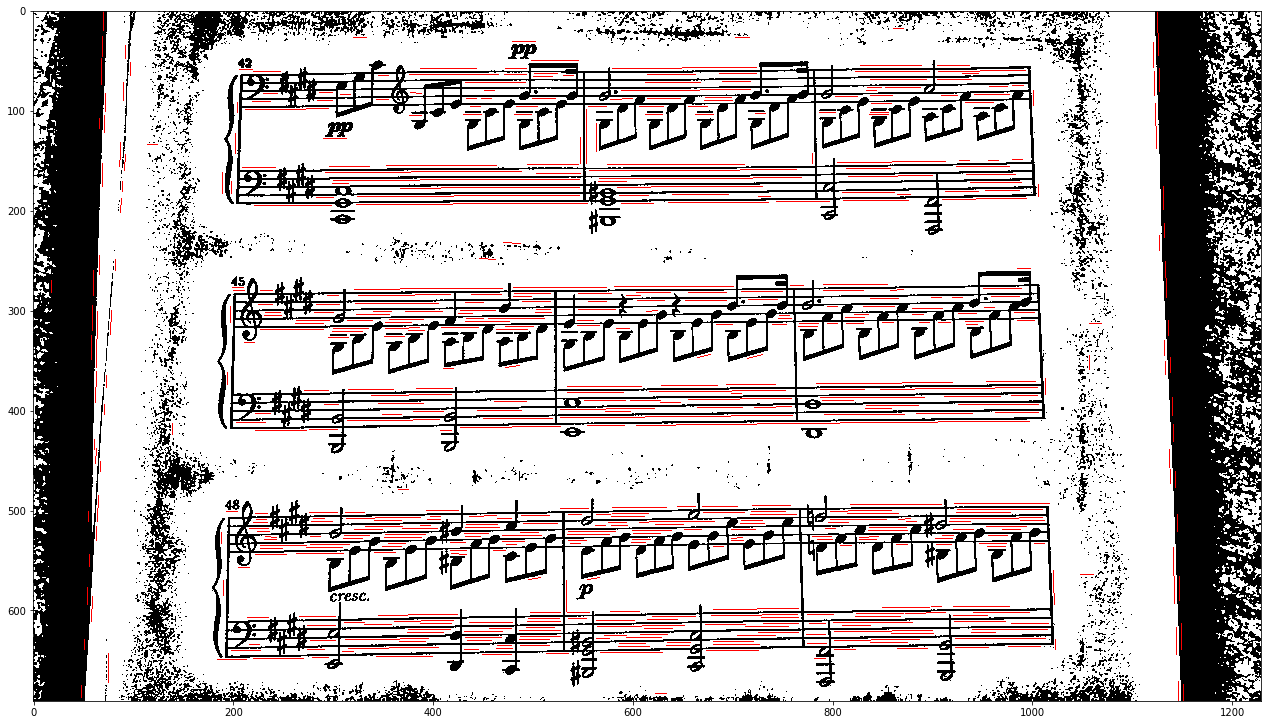

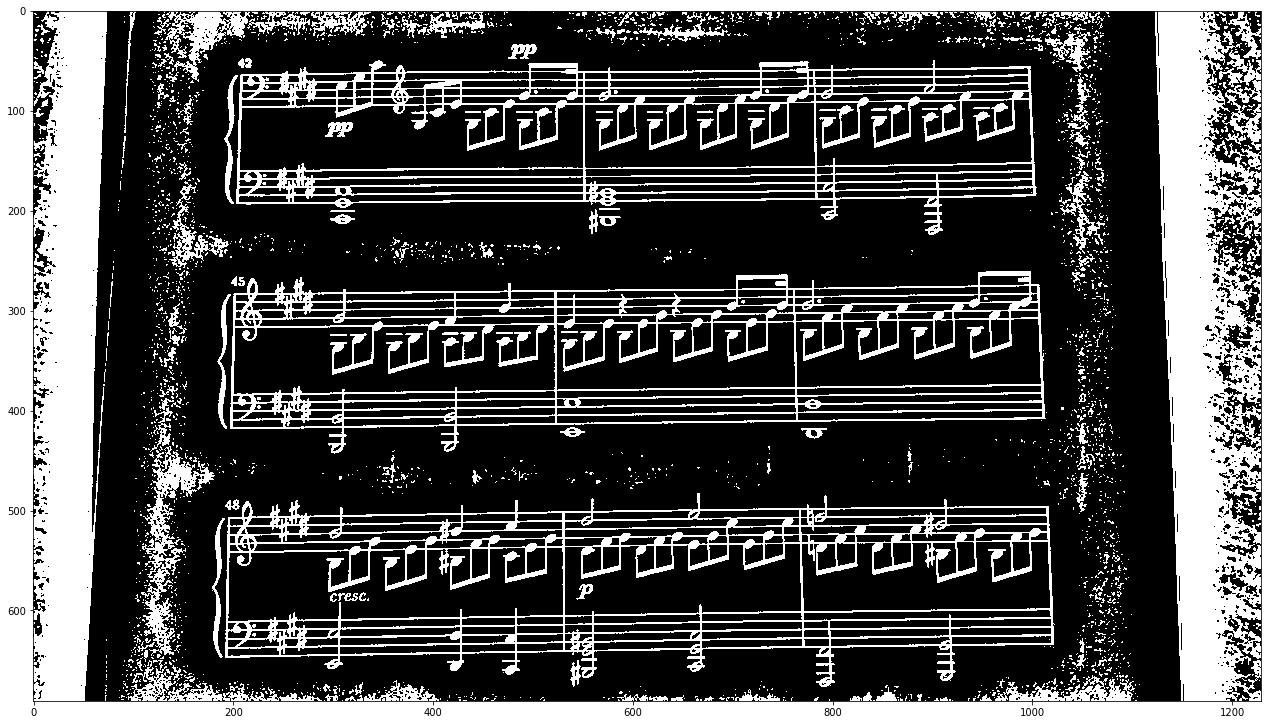

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(1.0, 16.0, 0, 1248)
(21.48611111111111, 0.25462962962962976, 545, 775)
(25.768844221105528, 0.12060301507537696, 557, 764)
(20.505208333333332, 0.3229166666666665, 563, 763)
(79.1515601783061, 1.1753343239227338, 198, 1015)
(78.431718061674, 1.0983847283406756, 199, 1015)
(95.11373707533235, 1.106351550960118, 199, 1016)
(94.70135746606334, 1.6184012066365008, 199, 1016)
(100.87535410764872, 2.1756373937677056, 618, 1018)
(167.00608828006088, 0.9726027397260273, 196, 1020)
(175.16413373860183, 1.0060790273556233, 196, 1020)
(183.30827067669173, 1.045112781954887, 196, 1020)
(191.3524096385542, 1.0753012048192772, 196, 1020)
(199.3121212121212, 1.043939393939394, 196, 1020)
(293.91788856304987, 0.9574780058651027, 192, 1024)
(291.4149855907781, 1.1008645533141213, 194, 1001)
(295.4320987654321, 0.9197530864197532, 252, 1023)
(305.81737849779086, 1.4845360824742269, 192, 1025)
(314.04740740740743, 1.505185185

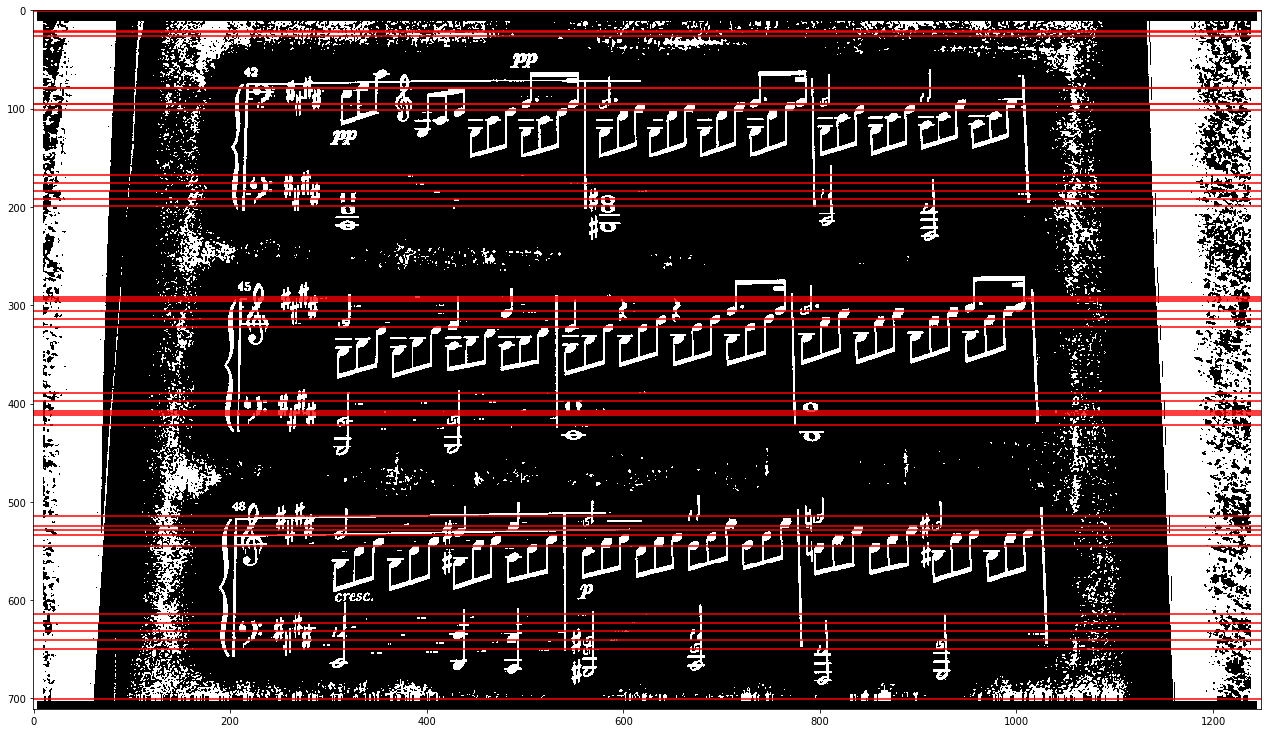

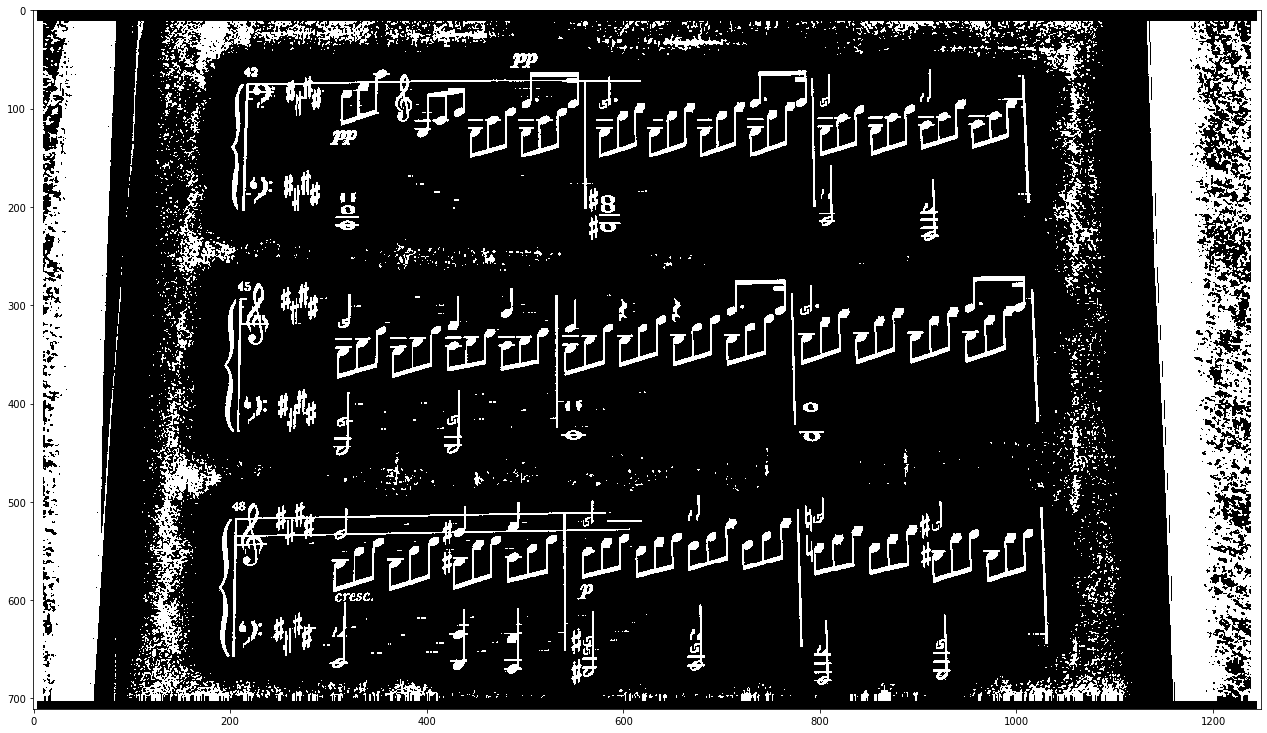

8.1468825340271

##############################   2   ##############################



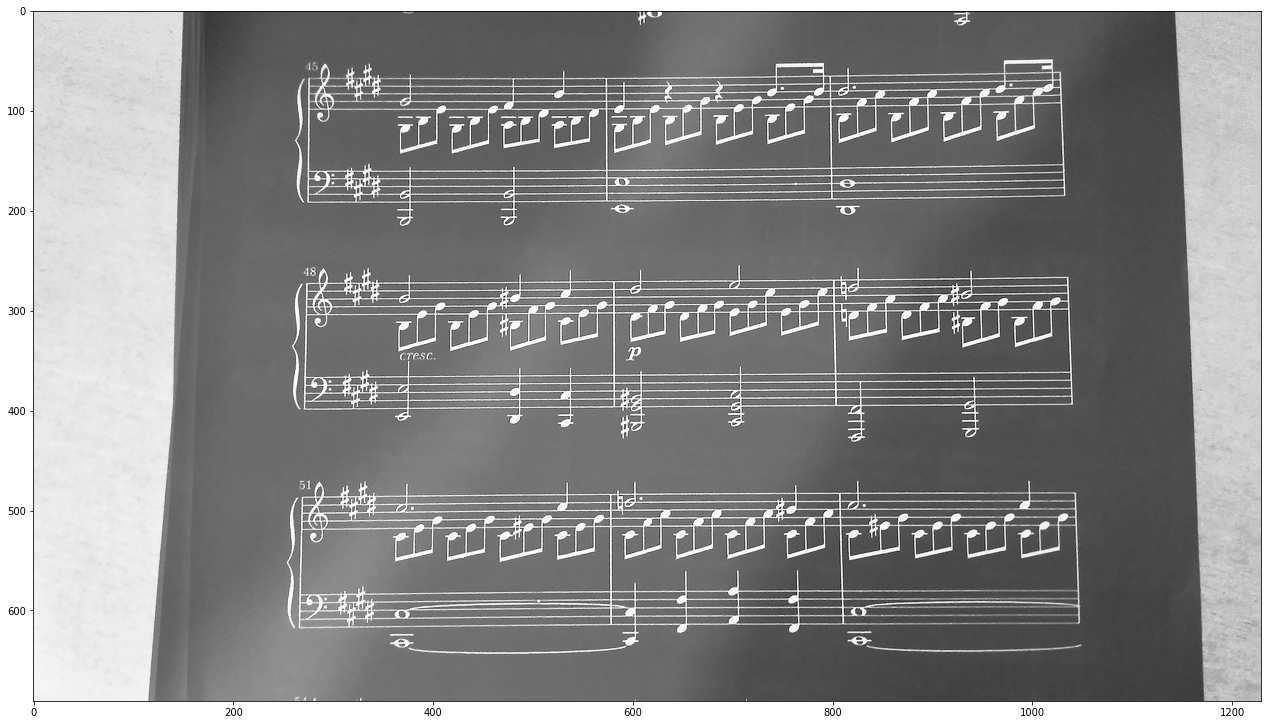

691 1229 0.0 0.0


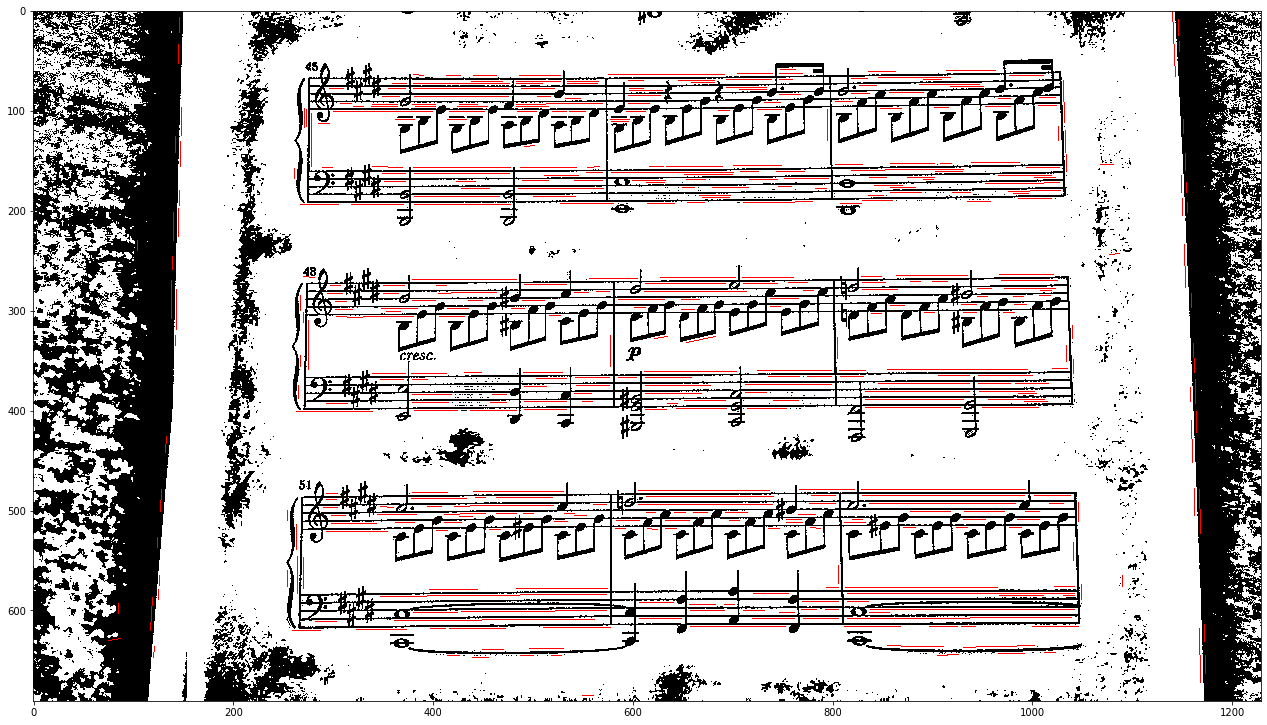

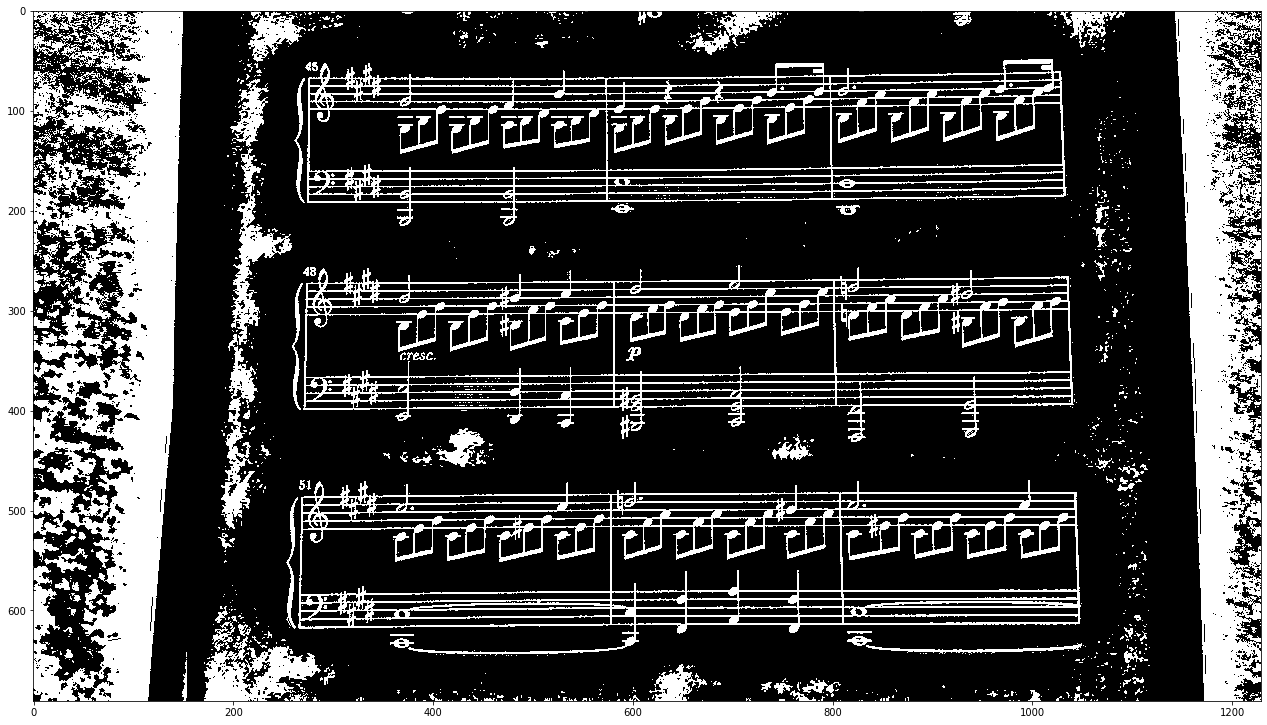

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(1.0, 16.0, 0, 1248)
(83.07176287051482, 1.126365054602184, 268, 1046)
(89.96615384615384, 1.3323076923076922, 268, 1046)
(103.02702702702703, 1.4222972972972974, 299, 973)
(96.34605597964376, 1.1272264631043258, 277, 931)
(100.81493506493507, 0.5487012987012987, 268, 677)
(108.12881355932204, 1.5254237288135593, 268, 642)
(168.9967741935484, 1.2161290322580647, 268, 917)
(177.8573619631902, 0.8680981595092025, 265, 1051)
(185.26072607260727, 0.8481848184818483, 267, 929)
(184.9367469879518, 0.8478915662650603, 267, 1050)
(200.08169934640523, 0.9183006535947711, 268, 910)
(198.14861460957178, 0.8639798488664989, 566, 1050)
(280.3058637083994, 0.7606973058637085, 266, 1054)
(288.126582278481, 0.8101265822784809, 266, 1054)
(296.5367412140575, 1.1293929712460065, 266, 1053)
(307.5526717557252, 1.7633587786259541, 266, 1054)
(307.17283950617286, 1.4074074074074074, 266, 1053)
(384.7708649468892, 0.8406676783004

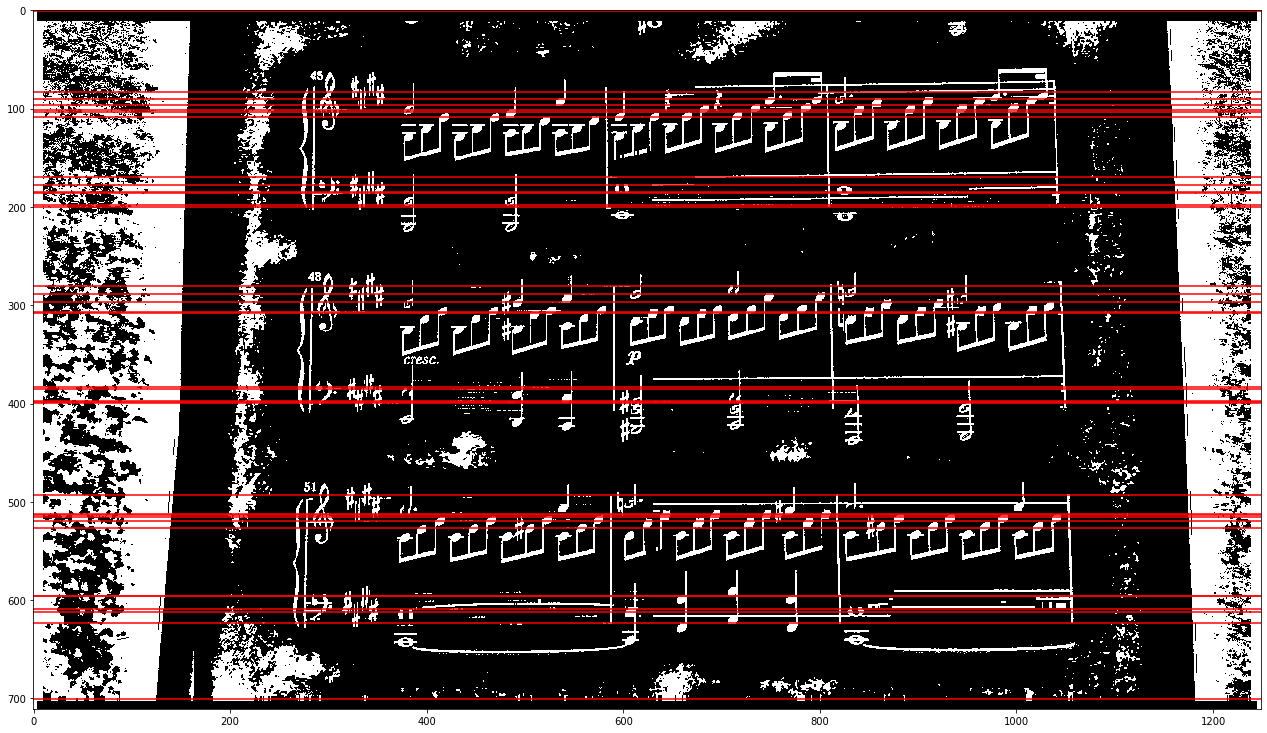

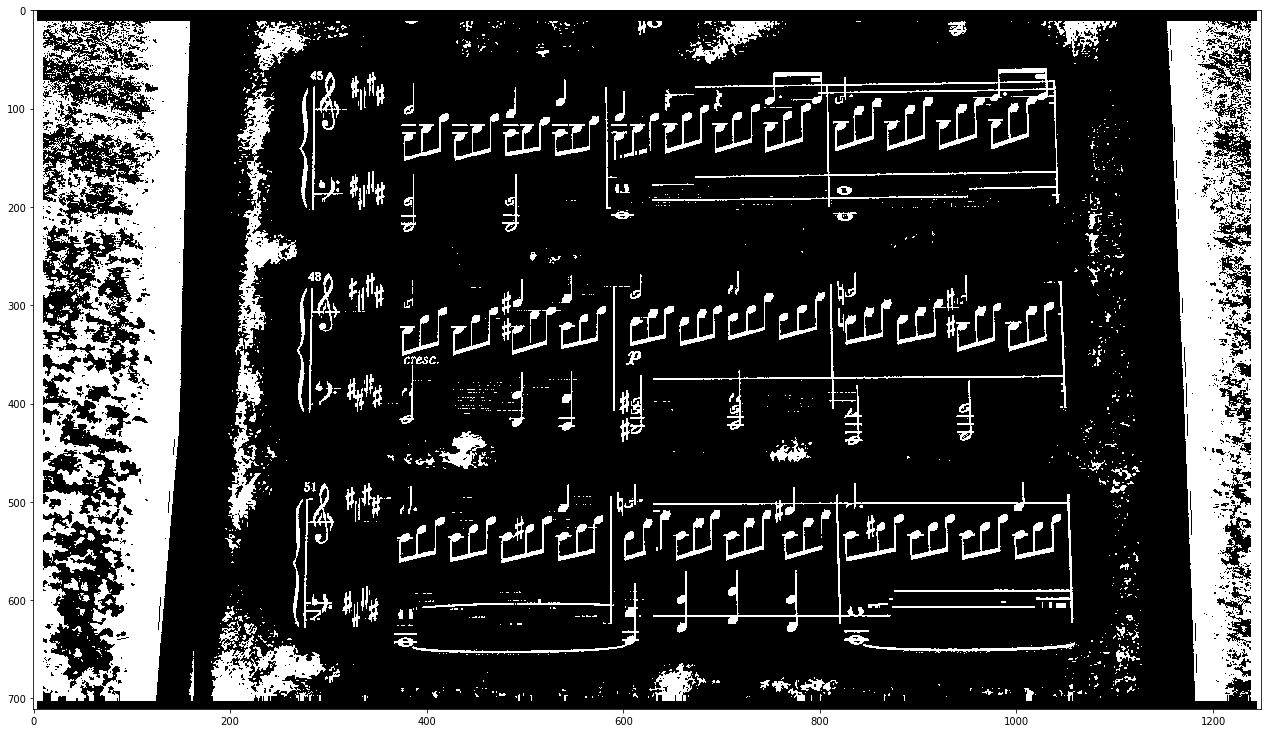

7.312523126602173

##############################   3   ##############################



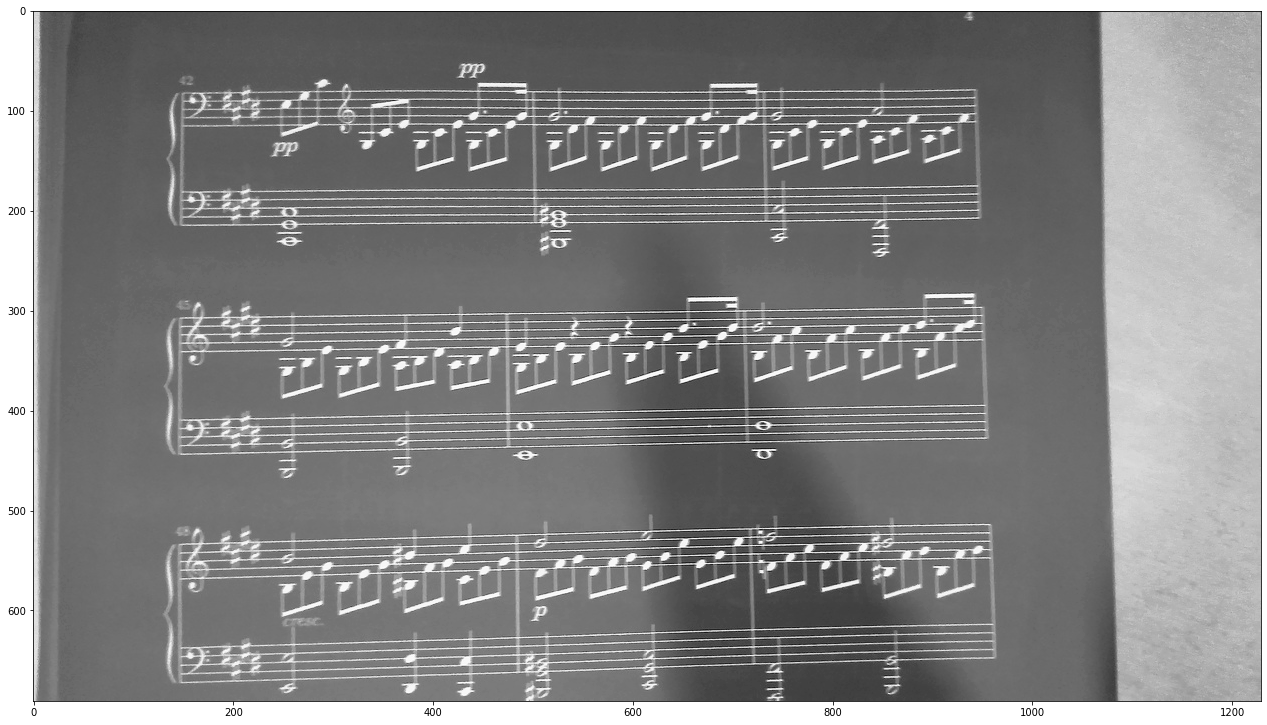

691 1229 0.0 0.0


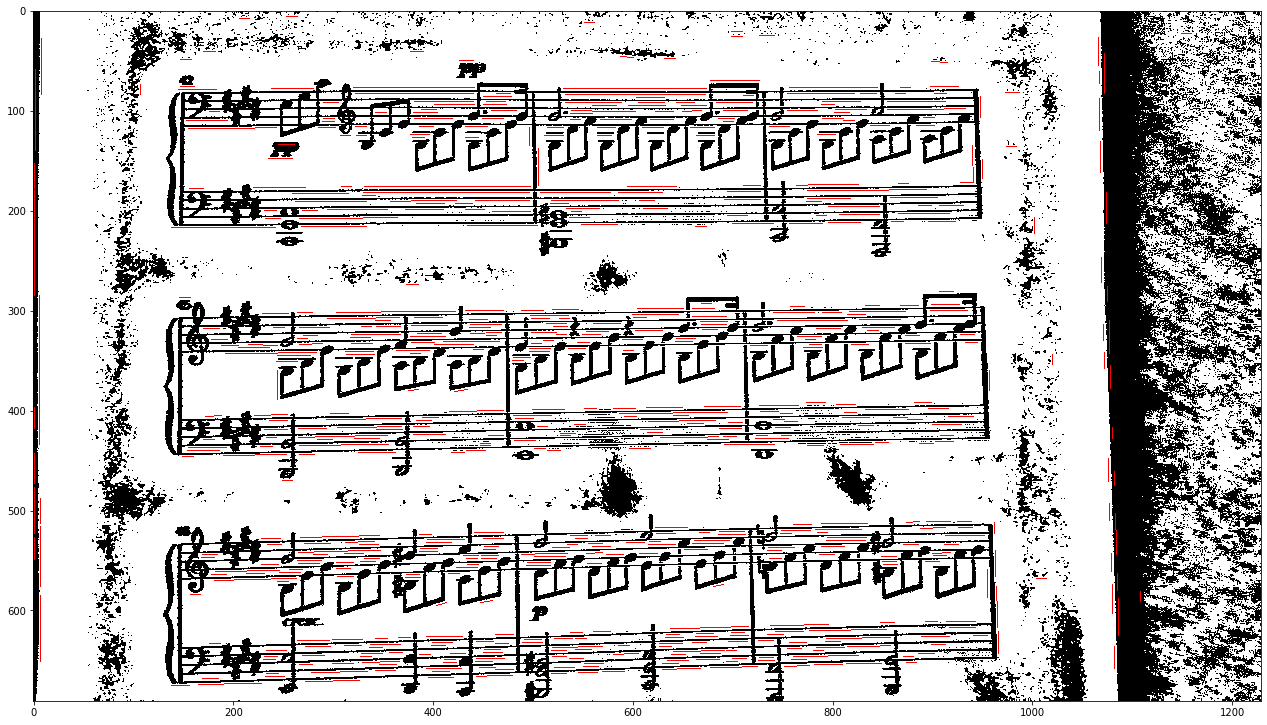

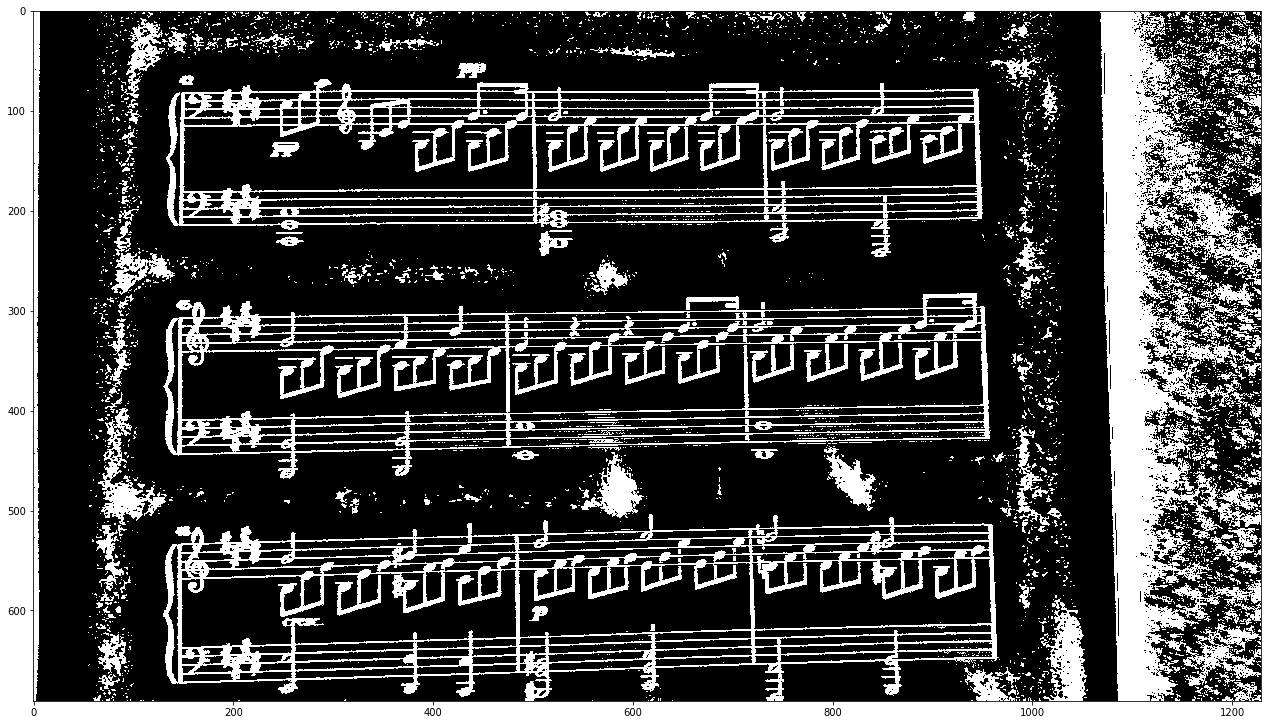

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(1.0, 16.0, 0, 1248)
(99.48816568047337, 1.2618343195266273, 139, 963)
(98.75254237288135, 0.7050847457627119, 418, 962)
(112.28313253012048, 1.2484939759036147, 140, 963)
(100.00759493670886, 1.6202531645569622, 140, 935)
(120.45015105740181, 1.879154078549849, 140, 963)
(123.25892857142857, 1.7619047619047619, 568, 963)
(188.79273827534038, 0.9062027231467473, 138, 966)
(197.00151515151515, 0.9136363636363636, 138, 966)
(205.2906626506024, 0.9156626506024095, 138, 966)
(213.57589285714286, 0.9196428571428572, 138, 966)
(221.46875, 0.8735119047619047, 138, 966)
(322.10289855072466, 0.8347826086956522, 136, 969)
(320.6502976190476, 0.7514880952380953, 137, 969)
(333.6253687315634, 1.2138643067846608, 137, 970)
(342.19293078055966, 1.7790868924889542, 137, 971)
(341.4451038575668, 1.2403560830860534, 294, 969)
(411.7448071216617, 0.7448071216617209, 136, 974)
(419.893175074184, 0.7878338278931749, 136, 974)
(

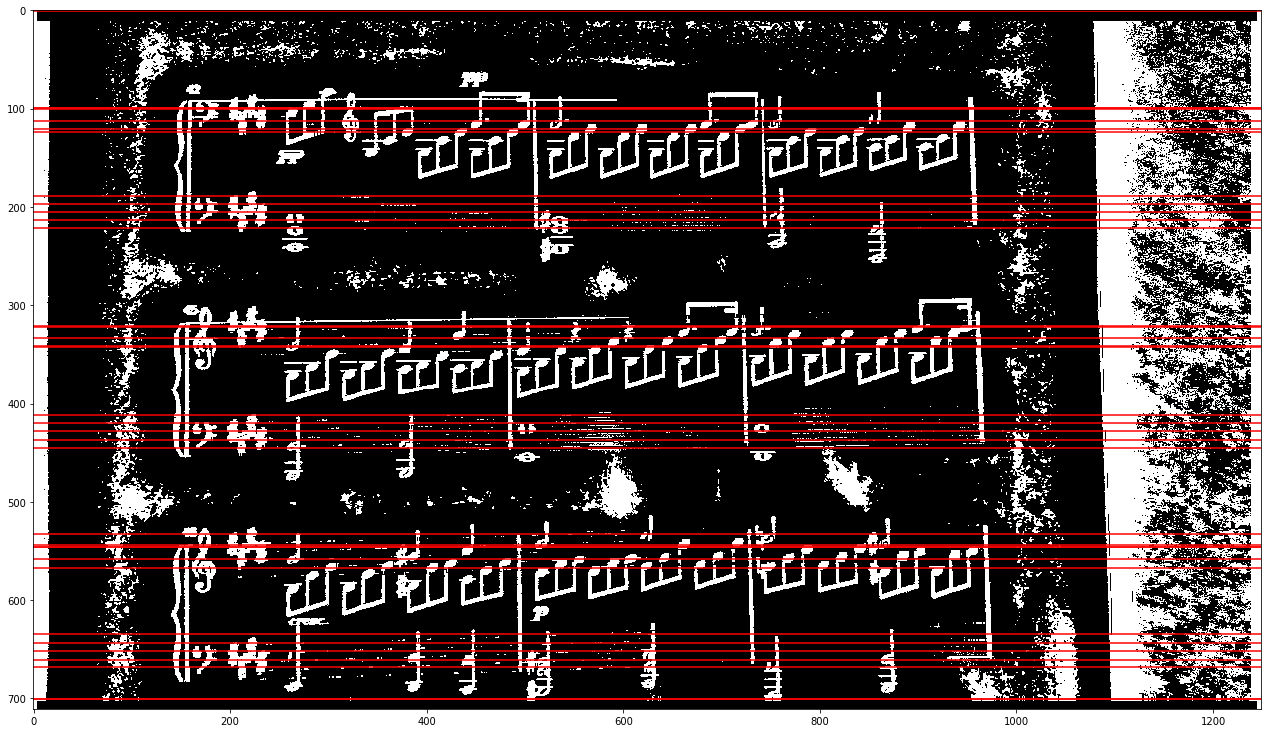

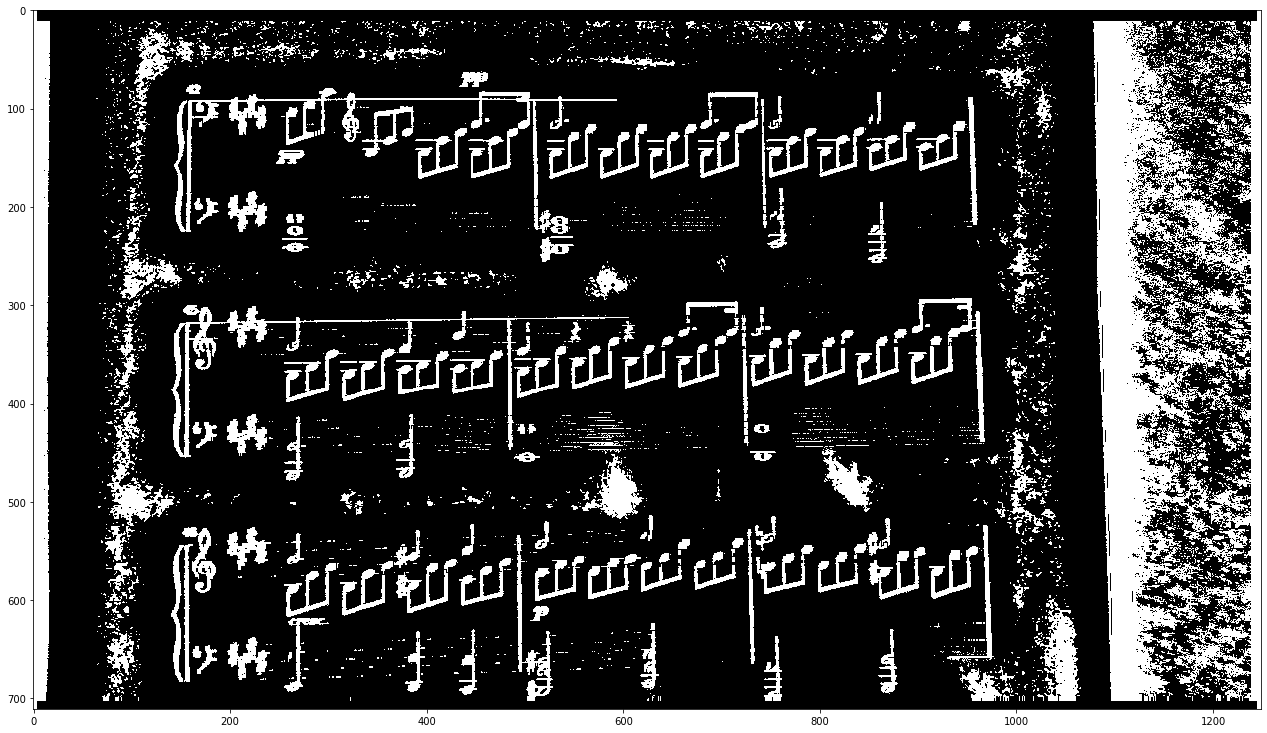

8.538613557815552

##############################   4   ##############################



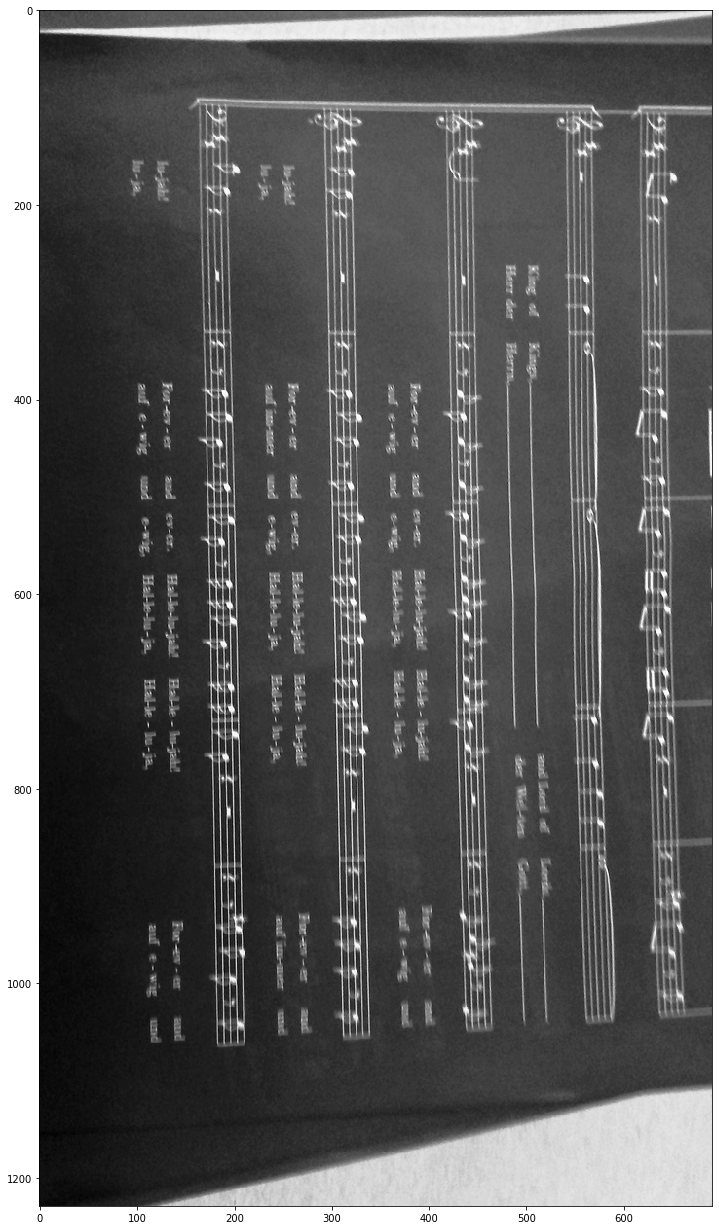

1229 691 90.0 1.0


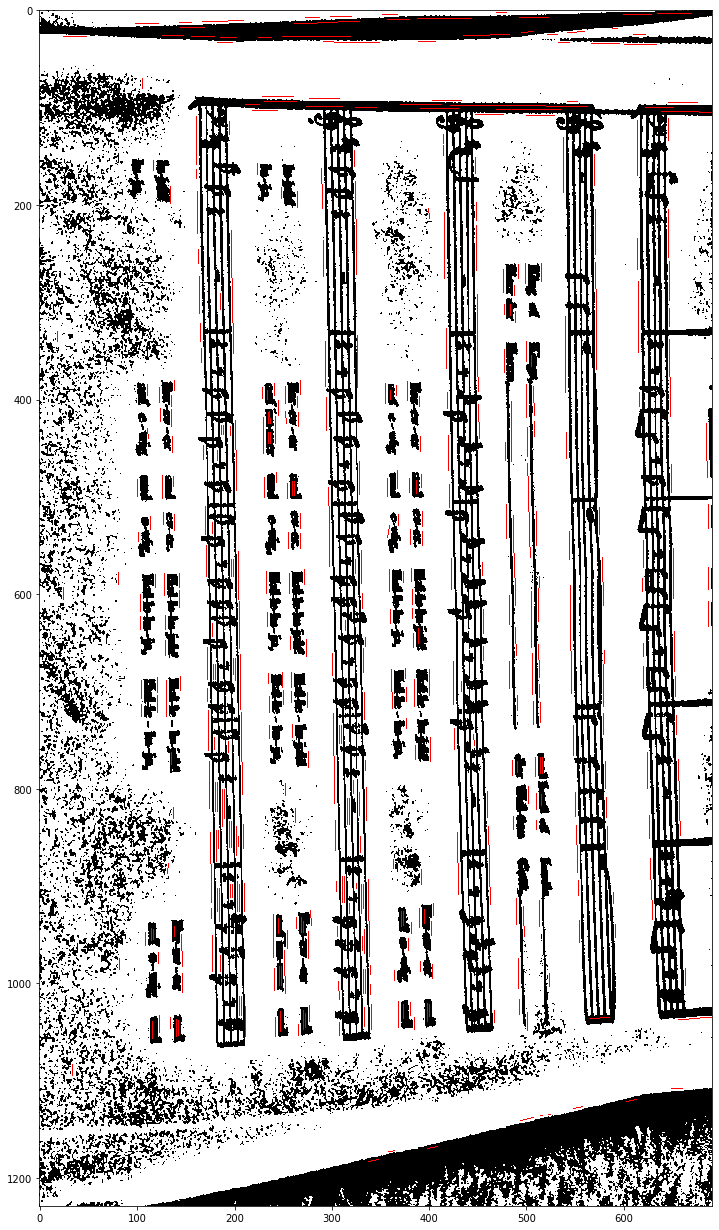

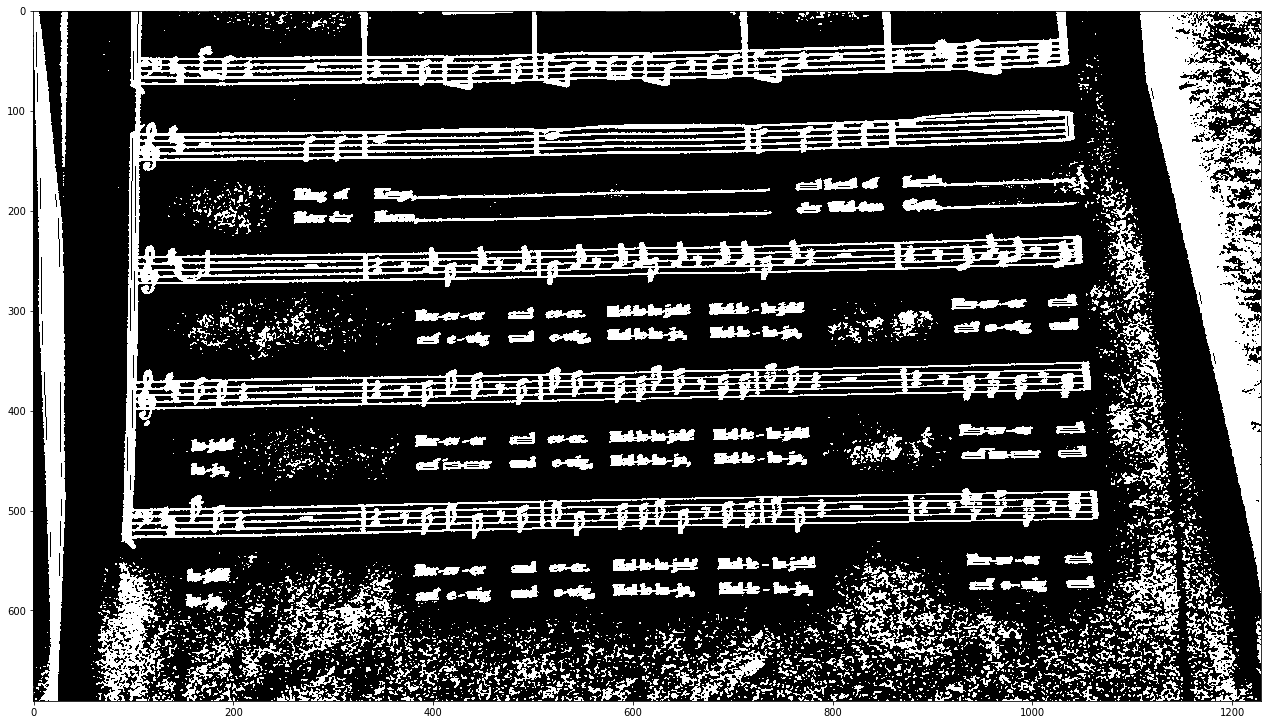

KeyboardInterrupt: 

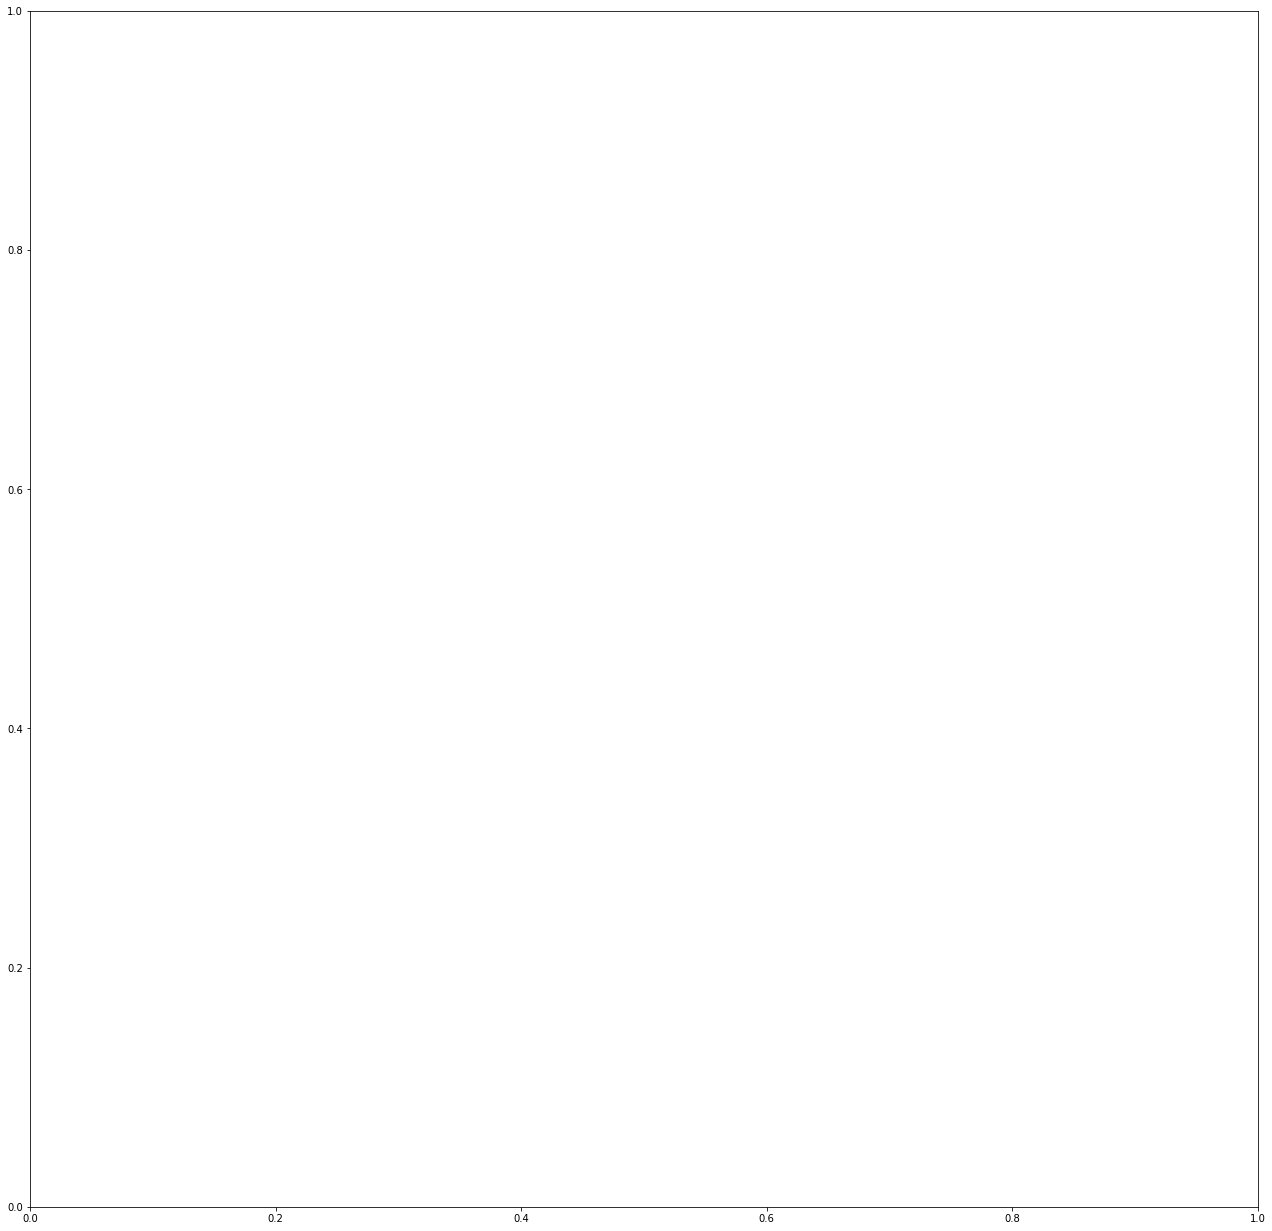

In [25]:
kernel=[0]*10
#kernele do grafiki
kernel[1]=np.asarray([[-1, -1, -1], [-1,8,-1], [-1, -1, -1]])
kernel[2]=np.asarray([[0, 1, 0], [1,-4,1], [0, 1, 0]])
kernel[3]=np.asarray([[0, 1, 0], [1,-5,1], [0, 1, 0]])
kernel[4]=(1/9)*np.asarray([[1, 1, 1], [1,1,1], [1, 1, 1]])
kernel[5]=(1/16)*np.asarray([[1, 2, 1], [2,4,2], [1, 2, 1]])
kernel[6]=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])
dm=(5,5)
kernel[7]=np.asarray([[1 for j in range(dm[0])] for i in range(dm[1])])
kernel[8]=np.asarray([[0, -1, 0], [-1,5,-1], [0, -1, 0]])

def binarization(bwimg):    
    edges = cv.Canny(bwimg,50,150,apertureSize = 3)
    edges=cv.filter2D(bwimg, -1, kernel[1])
    mg2=cv.filter2D(edges, -1, kernel[7])
    edges=cv.filter2D(bwimg, -1, kernel[2])
    mg3=cv.filter2D(edges, -1, kernel[7])
    bwimg=cv.adaptiveThreshold(bwimg, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 145, 1)
    #bwimg[mg2+mg3<30]=255
    
    return bwimg


def rotate_image(img, fimg):
    minLineLength = 50
    maxLineGap = 10
    
    kern=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])
    img2=cv.filter2D(img, -1, kernel[2])
    img2=cv.filter2D(img2, -1, kernel[7])
    edges = cv.Canny(img2,50,150,apertureSize = 3)
    lines = cv.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
    
    #print(lines)
    cosa=[0]*len(lines)
    sina=[0]*len(lines)
    for i, iv in enumerate(lines):
        x1,y1,x2,y2=iv[0]
        if (x2<x1 or (x2==x1 and y2<y1)):
            f1, f2=x1, y1
            x1, y1=x2, y2
            x2, y2=x1, y1
        
        dx, dy=(x2-x1), (y2-y1)
        
        if (dx*dx+dy*dy>0):
            cosa[i]=dy/math.sqrt(dy*dy+dx*dx)
        else:
            cosa[i]=0
        cv.line(img,(x1,y1),(x2,y2),(255,0,0),1)
    
    x=0
    blyat=[0]*210
    for i in range(len(cosa)):
        s=math.floor(cosa[i]*100)+100
        blyat[s]+=1
        if (blyat[s]>blyat[x]):
            x=s
    x=(x-100)/100
    #x2=np.mean(sina[i:n])
        
    angle=90-math.acos(x)*(180/math.pi)
    
    h, w = img.shape[:2]
    print(h, w, angle, x)
    image_center = (w/2, h/2)

    rotation_mat = cv.getRotationMatrix2D(image_center, angle, 1)

    radians = math.radians(angle)
    sin = math.sin(radians)
    cos = math.cos(radians)
    bound_w = int((h*abs(sin)) + (w*abs(cos)))
    bound_h = int((h*abs(cos)) + (w*abs(sin)))

    rotation_mat[0, 2] += ((bound_w / 2) - image_center[0])
    rotation_mat[1, 2] += ((bound_h / 2) - image_center[1])

    rotated_mat = cv.warpAffine(img, rotation_mat, (bound_w, bound_h), borderValue=255)
    
    kgbo=np.zeros((img.shape[0], img.shape[1], 3), dtype='uint8')
    kgbo[:,:,0]=img
    kgbo[:,:,1]=img
    kgbo[:,:,2]=img
        
    for i, iv in enumerate(lines):
        x1,y1,x2,y2=iv[0]
        dx, dy=(x2-x1), (y2-y1)

        cosa[i]=abs(dy)/math.sqrt(dy*dy+dx*dx)    
        cv.line(kgbo,(x1,y1),(x2,y2),(255,0,0),1)
        
    grave(kgbo)
    
    return rotated_mat


for i in range(j):
    t1=time.time()
    decorate(i)
    imgb=f[i].copy()
    grave(imgb, 1)
    shorig=imgb.shape
    
    ###BINARIZATION
    imv=binarization(imgb)
    #Rotacja po linii - czasem jeszcze nie działa
    img2=rotate_image(imv, imgb)
    grave(img2, 1)
    
    
    
    ss=np.zeros((img2.shape[0]+20, img2.shape[1]+20), dtype=str(img2.dtype))
    ss[10:-10,10:-10]=img2
    img2=ss.copy()
    
    ###DETECTION
    fig, ax=plt.subplots(1,1,figsize=(22,22))    
    sol=findlinez(img2, shorig)
    #sol - lista tupli - 1-wszy to uśrednione miejsce linii pięciolinii, 2-gi to grubość linii
    print('kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec')
    for x in sol:
        ax.axhline(x[0], color=(1,0,0))
        print(x)
    print('liczba liń z pięcioliń: {} (jak podzielna przez 5 to pewnie się zgadza)'.format(len(sol)))
    
    ax.imshow(img2, cmap='Greys',  interpolation='nearest')
    plt.show()
    
    grave(img2, 1)
    t2=time.time()
    print(t2-t1)
    

In [ ]:
#### 

In [ ]:
###Śmieci do recyklingu



##Bardzo efektywny do pdfów
kernel=[0]*10
#kernele do grafiki
kernel[1]=np.asarray([[-1, -1, -1], [-1,8,-1], [-1, -1, -1]])
kernel[2]=np.asarray([[0, 1, 0], [1,-4,1], [0, 1, 0]])
kernel[3]=np.asarray([[0, 1, 0], [1,-5,1], [0, 1, 0]])
kernel[4]=(1/9)*np.asarray([[1, 1, 1], [1,1,1], [1, 1, 1]])
kernel[5]=(1/16)*np.asarray([[1, 2, 1], [2,4,2], [1, 2, 1]])
kernel[6]=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])
dm=(7,7)
kernel[7]=np.asarray([[1 for j in range(dm[0])] for i in range(dm[1])])
kernel[8]=np.asarray([[0, -1, 0], [-1,5,-1], [0, -1, 0]])


for i in range(j):
    img=f[i].copy()
    grayscaled = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    img2=cv.adaptiveThreshold(grayscaled, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 35, 1)
    grave(img2)
    grave(img)
    
    
    
    
#To idzie do lamusa
def detect_5(bwimg):
    cs=0
    jj=0
    bethon=[0]*1000
    x=0
    cdis=80
    v1, v2=10, cdis+10
    
    while (x<len(bwimg)-v1):
        svv=((255-bwimg[x:x+cdis,:])//255).astype('int32')
        svg=(sorted(np.sum(svv, axis=1), reverse=1))
        stv=zip(range(x, x+cdis), np.sum(svv, axis=1))
        stv=(sorted(stv, key=lambda x:x[1], reverse=1))
        
        svv2=((255-bwimg[x+v1:x+v2,:])//255).astype('int32')
        svg2=(sorted(np.sum(svv2, axis=1), reverse=1))
        stv2=zip(range(x+v1, x+v2), np.sum(svv2, axis=1))
        stv2=(sorted(stv2, key=lambda x:x[1], reverse=1))
        
        #Ta heura na razie jest koszmarna i nieuniwersalizowalna, choć idea pewnie dobra
        if (len(svg2)>5 and svg[4]==svg2[4] and svg[4]>0.6*bwimg.shape[1] and distinct(stv)==1):
            bethon[jj]=(x+5, x+cdis+5, stv2[:15])
            jj+=1
            x+=cdis
        else:
            x+=1
    return (bethon[:jj])


#Bierze imidż zarotowany równolegle do górnej krawędzi obrazka
def distinct(arr):
    st=sorted(arr, key=lambda x:x[0])
    j=0
    dist=1
    while (j<len(arr)):
        if (0.8*arr[0][1]>arr[j][1]):
            break
        if (j>0 and arr[j][0]-arr[j-1][0]>3):
            dist+=1
        j+=1
    return (1 if dist>=5 else 0)



    
    
    
    kgbo=np.zeros((img.shape[0], img.shape[1], 3), dtype='uint8')
    kgbo[:,:,0]=img
    kgbo[:,:,1]=img
    kgbo[:,:,2]=img
        
    for i, iv in enumerate(lines):
        x1,y1,x2,y2=iv[0]
        dx, dy=(x2-x1), (y2-y1)

        cosa[i]=abs(dy)/math.sqrt(dy*dy+dx*dx)    
        cv.line(kgbo,(x1,y1),(x2,y2),(255,0,0),1)
        
    grave(kgbo)
    
    """
            for i,x in enumerate(pathway):
                if (i==0):
                    continue
                if (bwimg[pathway[i][0],pathway[i][1]]==255):
                    if (bwimg[pathway[i-1][0],pathway[i][1]]==0):
                        pathway[i][0]=pathway[i-1][0]
                    else:
                        tv=pathway[i][0]
                        while (bwimg[tv, pathway[i][1]]==255):
                            tv=tv+jj
                            jj=-jj-1*jj//abs(jj)                             
                        cur-=1
            """

In [42]:
c=[(1,2),(3,4),(5,6)]
print(np.asarray(c))

[[1 2]
 [3 4]
 [5 6]]


In [ ]:
%%cython
import numpy as np
import math
cimport numpy as np
from cpython cimport array
import array


def blackening(np.ndarray[unsigned char, ndim=2] bwimg, np.ndarray[int, ndim=2] path):
    cdef int s=0, t=0, gr=0, ij, i, jj
    cdef np.ndarray[int, ndim=1] dep=np.zeros((len(path)), dtype='int32')
    cdef np.ndarray[int, ndim=1] end1=np.zeros((len(path)), dtype='int32')
    cdef np.ndarray[int, ndim=1] end2=np.zeros((len(path)), dtype='int32')
    
    for i in range(0, len(path)):
        for ij in range(0, -10, -1):
            a, b=path[i][0]+ij, path[i][1]
            if (bwimg[a,b]==255):
                break
        end1[i]=ij
        
        for ij in range(1, 10, 1):
            a, b=path[i][0]+ij, path[i][1]
            
            if (bwimg[a,b]==255):
                break
        end2[i]=ij
        
        dep[i]=end2[i]-end1[i]
    ld=len(dep)
    dep2=sorted(dep)
    small=dep2[math.floor(0.1*ld)]
    large=dep2[math.floor(0.9*ld)]
    
    dep2=dep2[math.floor(0.1*ld):math.floor(0.9*ld)]
    grub=sum(dep2)/len(dep2)-2
    #print('DEPTH {} {}'.format(grub, dep))
    
    midian=[0]*len(path)
    cur=0
    last=0
    midian[0]=path[0][0]
    for i in range(1, len(path)):
        if (dep[i]>grub+3):
            cur+=1
            continue
        else:
            midian[i]=path[i][0]+(end2[i]+end1[i])//2
            while (cur>0):
                p=path[i][0]-cur
                midian[i-cur]=midian[i] if (cur<p-last) else midian[last]
                tv=midian[i-cur]
                jj=1
                while (bwimg[tv, path[i-cur][1]]==255):
                    tv=tv+jj
                    jj=-jj-1*jj//abs(jj) 
                midian[i-cur]=tv
                cur-=1
            last=i
            
    #print(list(zip(path, midian)))
    dt0=math.ceil(grub)
    for i in range(len(path)):
        sc, t1, t2=0, 0, 0
        for jj in range(1, 10):
            if (bwimg[midian[i]+jj, path[i][1]]==255):
                break
        t1=jj
        for jj in range(0, -10, -1):
            if (bwimg[midian[i]+jj, path[i][1]]==255):
                break
        t2=jj
        sc=t1-t2
        
        if (sc<=dt0+3):
            for jj in range(t2, t1+1, 1):
                bwimg[midian[i]+jj, path[i][1]]=255
    c1=math.floor(0.1*len(midian))
    c2=math.floor(0.9*len(midian))
    
    return (sum(midian[c1:c2])/len(midian[c1:c2]), grub)


def cleanblack(bwimg, pathway):
    for x in pathway:
        bwimg[x[0]-2:x[0]+2,x[1]]=255
    return (1,2)

#limit - o ile y może się odchylić od y2
def pathfinder(np.ndarray[unsigned char, ndim=2] bwimg, np.ndarray[int, ndim=2] F, np.ndarray[unsigned char, ndim=2] check, np.ndarray[int, ndim=1] par, np.ndarray[int, ndim=1] w, awp, awm, int y, int x, int p, int vv, int lowx, int highx, int y2, np.ndarray[int, ndim=1] miss):
    cdef int limit=30, l2=6
    
    if (y>=bwimg.shape[0] or x>=bwimg.shape[1] or x<0 or y<0 or abs(y-y2)>limit):
        return (p, lowx, highx)
    if (check[y,x]==0 and (bwimg[y,x]==0 or miss[vv]<l2)):
        if (bwimg[y,x]==255):
            miss[p]=miss[vv]+1
        else:
            miss[p]=0
        F[p,0]=y
        F[p,1]=x
        check[y,x]=1
        par[p]=vv
        if (x<lowx):
            lowx=x
            awm.append(p)
            w[p]=-1
        elif (x>highx):
            highx=x
            awp.append(p)
            w[p]=1
        else:
            w[p]=0
        return (p+1, lowx, highx)
    return (p, lowx, highx)


def findlinez(np.ndarray[unsigned char, ndim=2] bwimg, shp):
    cdef int skv=2, y=1, kk=1, iF=0, jF=1, deadl=0, deadr=1, highx, lowx, x1, x2, conn=1000, C=100000
    solution=[]
    cdef np.ndarray[unsigned char, ndim=2] check=np.zeros((bwimg.shape[0], bwimg.shape[1]), dtype='uint8')
    cdef np.ndarray[int, ndim=1] par=np.zeros((C), dtype='int32')
    cdef np.ndarray[int, ndim=1] miss=np.zeros((C), dtype='int32')
    cdef np.ndarray[int, ndim=1] w=np.zeros((C), dtype='int32')
    
    cdef np.ndarray[int, ndim=2] F=np.zeros((C, 2), dtype='int32')
    #cdef np.ndarray[int, ndim=1] pathway=np.zeros((C), dtype='int32')
    
    for kk in range(1, skv):
        y=1
        x1=(kk*bwimg.shape[1])//skv-2
        x2=(kk*bwimg.shape[1])//skv+2
        
        while (y<bwimg.shape[0]-1):
            vs=bwimg[y,x1:x2+1]
            if (0 in vs):
                xl=kk*(bwimg.shape[1]//skv)
                yl=y
                
                pathway=[]
                
                F[0,0]=yl
                F[0,1]=xl
                
                par[0]=-1
                w[0]=0
                awp=[]
                awm=[]
                miss[0]=0
                
                highx, lowx=xl, xl
                deadl, deadr=0, 0
                pointdead=[0,0]
                iF, jF=0, 1
                conn=1000
                
                while(iF<jF):
                    s=F[iF]
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, awp, awm, s[0]-1, s[1], jF, iF, lowx, highx, y, miss)
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, awp, awm, s[0]+1, s[1], jF, iF, lowx, highx, y, miss)
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, awp, awm, s[0], s[1]-1, jF, iF, lowx, highx, y, miss)
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, awp, awm, s[0], s[1]+1, jF, iF, lowx, highx, y, miss)
                    
                    if (len(awp)>4 and awp[-5]<jF-conn and deadr==0):
                        deadr=1
                        pointdead[1]=jF-conn
                    if (len(awm)>4 and awm[-5]<jF-conn and deadl==0):
                        deadl=1
                        pointdead[0]=jF-conn
                    if (deadl==1 and deadr==1):
                        break
                    iF+=1
                if (pointdead[0]==0):
                    pointdead[0]=jF-1
                if (pointdead[1]==0):
                    pointdead[1]=jF-1
                #print(y, jF, lowx, highx)
                #print('PedE', pointdead, jF, highx, lowx)
                j1=pointdead[0]
                for j1 in range(pointdead[0], -1, -1):
                    if (w[j1]==-1):
                        break
                while (j1>=0):
                    pathway.append((F[j1,0],F[j1,1]))
                    j1=par[j1]
                
                j2=pointdead[1]
                for j2 in range(pointdead[1], -1, -1):
                    if (w[j2]==1):
                        break
                
                p2=[]
                while (j2>0):
                    p2.append((F[j2,0],F[j2,1]))
                    j2=par[j2]
                
                pathway.extend(p2[::-1])
                for j in range(jF):
                    check[F[j,0], F[j,1]]=0
                
                if (highx-lowx>shp[1]*0.15):
                    sv, gr=blackening(bwimg, np.asarray(pathway))
                    #sv, gr=cleanblack(bwimg, pathway)
                    solution.append((sv, gr, lowx, highx))
            y+=1
    return solution